# Лабораторная работа № 4

Задание:
1. Модель должна научиться классифицировать текст
2. Должны выполнены три реализации модели. Реализации должны быть основаны на использовании:
    - одномерной сверточной нейросети
    - рекуррентной нейросети LSTM
    - рекуррентной нейросети GRU
3. Выполнить сравнение полученных результатов и сделать вывод

Исходные данные:
- для обучения: https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/train.csv
- для тестирования: https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/test.csv
- имена классов: https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/classes.txt

# Импорт необходимых библиотек

In [1]:
import pandas as pd  # Библиотека для работы с данными
import tensorflow as tf  # Библиотека для создания и обучения нейросетей
from tensorflow.keras.preprocessing.text import Tokenizer  # Класс для токенизации текста
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Функция для выравнивания последовательностей
from tensorflow.keras.models import Sequential  # Класс для создания модели последовательной структуры
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, LSTM, GRU  # Различные слои для нейросетей
import matplotlib.pyplot as plt  # Библиотека для построения графиков
import time  # Модуль для работы со временем (измерение времени обучения)

# Выбор устройства

In [2]:
device_name = tf.test.gpu_device_name()  # Проверка доступности GPU. Возвращает имя устройства GPU, если оно найдено.
if device_name:
    print(f'Использование GPU: {device_name}')  # Если GPU найдено, выводится имя устройства GPU.
else:
    print('GPU не найдено, использование CPU.')  # Если GPU не найдено, выводится сообщение о использовании CPU.


GPU не найдено, использование CPU.


# Загрузка данных и предварительная обработка

In [4]:
# Загрузка данных из локальных файлов
train_df = pd.read_csv('train.csv', header=None)  # Загрузка обучающего набора данных из файла train.csv
test_df = pd.read_csv('test.csv', header=None)  # Загрузка тестового набора данных из файла test.csv

# Назначение имен колонкам
train_df.columns = ['class', 'title', 'description']  # Назначение имен колонкам обучающего набора данных
test_df.columns = ['class', 'title', 'description']  # Назначение имен колонкам тестового набора данных

# Проверка загруженных данных
print(train_df.head())  # Вывод первых нескольких строк обучающего набора данных для проверки

# Параметры
max_words = 10000  # Максимальное количество уникальных слов для токенизации
max_len = 200  # Максимальная длина последовательности

# Токенизация и преобразование текстов в последовательности
tokenizer = Tokenizer(num_words=max_words)  # Создание токенизатора с ограничением на количество слов
tokenizer.fit_on_texts(train_df['description'])  # Обучение токенизатора на текстах из обучающего набора данных

sequences_train = tokenizer.texts_to_sequences(train_df['description'])  # Преобразование текстов обучающего набора данных в последовательности чисел
sequences_test = tokenizer.texts_to_sequences(test_df['description'])  # Преобразование текстов тестового набора данных в последовательности чисел

# Подгонка последовательностей по длине
X_train = pad_sequences(sequences_train, maxlen=max_len)  # Подгонка длины последовательностей обучающего набора данных до max_len
X_test = pad_sequences(sequences_test, maxlen=max_len)  # Подгонка длины последовательностей тестового набора данных до max_len

# Преобразование классов в one-hot encoding
y_train = pd.get_dummies(train_df['class']).values  # Преобразование классов обучающего набора данных в формат one-hot encoding
y_test = pd.get_dummies(test_df['class']).values  # Преобразование классов тестового набора данных в формат one-hot encoding


   class                                              title  \
0      3  Wall St. Bears Claw Back Into the Black (Reuters)   
1      3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2      3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3      3  Iraq Halts Oil Exports from Main Southern Pipe...   
4      3  Oil prices soar to all-time record, posing new...   

                                         description  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil prices, toppling reco...  


# Создание и обучение моделей

# Одномерная Сверточная Нейросеть (CNN)

Одномерные сверточные нейросети (Convolutional Neural Networks, CNN) часто используются для анализа последовательных данных. Они особенно хорошо справляются с задачами, где важны локальные паттерны (например, последовательности слов или символов).

Принцип работы:

Embedding Layer (Слой Встраивания): Преобразует слова в векторы фиксированной размерности.

Conv1D Layer (Сверточный Слой): Применяет фильтры к входным данным, извлекая локальные паттерны. В нашем случае, мы используем 128 фильтров с размером 5.

MaxPooling1D Layer (Слой Подвыборки): Уменьшает размерность данных, выбирая максимум из каждых 5 элементов, чтобы уменьшить шум и сохранить важные признаки.

GlobalMaxPooling1D Layer (Глобальный Слой Подвыборки): Еще больше уменьшает размерность, агрегируя информацию по всей последовательности.

Dense Layer (Полносвязный Слой): Производит классификацию, используя функцию активации softmax для получения вероятностей классов.

Особенности:

Хорошо справляется с локальными паттернами.

Эффективность при работе с большими наборами данных.

In [5]:
# Создание модели последовательной структуры, что позволяет добавлять слои один за другим
model_cnn = Sequential()

# Добавление слоя встраивания (Embedding Layer):
# - max_words: Максимальное количество уникальных слов для токенизации
# - 128: Размерность векторного представления каждого слова
# - input_length: Максимальная длина входной последовательности
model_cnn.add(Embedding(max_words, 128, input_length=max_len))

# Добавление сверточного слоя (Conv1D Layer):
# - 128: Количество фильтров (kernels) в слое
# - 5: Размер фильтра (ширина окна свертки)
# - activation='relu': Функция активации ReLU (Rectified Linear Unit) для нелинейности
model_cnn.add(Conv1D(128, 5, activation='relu'))

# Добавление слоя подвыборки (MaxPooling1D Layer):
# - 5: Размер окна подвыборки (pool size), что уменьшает размерность данных
model_cnn.add(MaxPooling1D(5))

# Добавление глобального слоя подвыборки (GlobalMaxPooling1D Layer):
# - Этот слой выбирает максимальные значения по всей длине входной последовательности, 
#   что приводит к одновременному уменьшению размерности и агрегации важной информации
model_cnn.add(GlobalMaxPooling1D())

# Добавление полносвязного слоя (Dense Layer):
# - 4: Количество выходных нейронов, соответствующих количеству классов в задачах классификации
# - activation='softmax': Функция активации softmax, которая нормализует выходные значения в вероятности для каждого класса
model_cnn.add(Dense(4, activation='softmax'))

# Компиляция модели:
# - optimizer='adam': Оптимизатор Adam для адаптивного изменения скорости обучения во время обучения модели
# - loss='categorical_crossentropy': Функция потерь categorical crossentropy, подходящая для многоклассовой классификации
# - metrics=['accuracy']: Метрика точности для оценки производительности модели
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Измерение времени обучения модели CNN
cnn_start_time = time.time()  # Запуск таймера
history_cnn = model_cnn.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)  # Обучение модели
cnn_end_time = time.time()  # Остановка таймера
cnn_time = cnn_end_time - cnn_start_time  # Вычисление времени обучения


Epoch 1/5


C:\Users\Digital Razor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - accuracy: 0.8117 - loss: 0.5201 - val_accuracy: 0.8934 - val_loss: 0.3107
Epoch 2/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - accuracy: 0.9354 - loss: 0.1916 - val_accuracy: 0.8916 - val_loss: 0.3203
Epoch 3/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - accuracy: 0.9651 - loss: 0.1052 - val_accuracy: 0.8835 - val_loss: 0.3803
Epoch 4/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - accuracy: 0.9857 - loss: 0.0509 - val_accuracy: 0.8763 - val_loss: 0.4820
Epoch 5/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - accuracy: 0.9915 - loss: 0.0334 - val_accuracy: 0.8800 - val_loss: 0.5112


# Рекуррентная Нейросеть LSTM

LSTM (Long Short-Term Memory) - это разновидность рекуррентных нейросетей, которые могут обучаться и запоминать долгосрочные зависимости в последовательных данных, что делает их полезными для задач, где важен порядок и контекст.

Принцип работы:

Embedding Layer (Слой Встраивания): Преобразует слова в векторы фиксированной размерности.

LSTM Layer: Специально разработан для запоминания долгосрочных зависимостей в данных. Содержит ячейки памяти, которые могут сохранять информацию на долгое время.

Dense Layer (Полносвязный Слой): Производит классификацию, используя функцию активации softmax для получения вероятностей классов.

Особенности:

Способность запоминать и учитывать долгосрочные зависимости и контексты.

Эффективность в задачах, где важен порядок элементов, например, в анализе текста или временных рядов.

In [6]:
# Создание модели последовательной структуры, что позволяет добавлять слои один за другим
model_lstm = Sequential()

# Добавление слоя встраивания (Embedding Layer):
# - max_words: Максимальное количество уникальных слов для токенизации
# - 128: Размерность векторного представления каждого слова
# - input_length: Максимальная длина входной последовательности
model_lstm.add(Embedding(max_words, 128, input_length=max_len))

# Добавление слоя LSTM:
# - 128: Количество нейронов в слое LSTM
# Этот слой предназначен для запоминания долгосрочных зависимостей в данных
model_lstm.add(LSTM(128))

# Добавление полносвязного слоя (Dense Layer):
# - 4: Количество выходных нейронов, соответствующих количеству классов в задачах классификации
# - activation='softmax': Функция активации softmax, которая нормализует выходные значения в вероятности для каждого класса
model_lstm.add(Dense(4, activation='softmax'))

# Компиляция модели:
# - optimizer='adam': Оптимизатор Adam для адаптивного изменения скорости обучения во время обучения модели
# - loss='categorical_crossentropy': Функция потерь categorical crossentropy, подходящая для многоклассовой классификации
# - metrics=['accuracy']: Метрика точности для оценки производительности модели
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Измерение времени обучения модели LSTM
lstm_start_time = time.time()  # Запуск таймера
history_lstm = model_lstm.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)  # Обучение модели
lstm_end_time = time.time()  # Остановка таймера
lstm_time = lstm_end_time - lstm_start_time  # Вычисление времени обучения


Epoch 1/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 229s 76ms/step - accuracy: 0.8086 - loss: 0.5117 - val_accuracy: 0.8958 - val_loss: 0.3066
Epoch 2/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 230s 77ms/step - accuracy: 0.9220 - loss: 0.2377 - val_accuracy: 0.8958 - val_loss: 0.3100
Epoch 3/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 233s 78ms/step - accuracy: 0.9405 - loss: 0.1764 - val_accuracy: 0.8865 - val_loss: 0.3313
Epoch 4/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 234s 78ms/step - accuracy: 0.9558 - loss: 0.1287 - val_accuracy: 0.8868 - val_loss: 0.3652
Epoch 5/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 235s 78ms/step - accuracy: 0.9694 - loss: 0.0898 - val_accuracy: 0.8813 - val_loss: 0.4109


# Рекуррентная Нейросеть GRU

GRU (Gated Recurrent Unit) - это разновидность рекуррентных нейросетей, аналогичная LSTM, но с упрощенной архитектурой. GRU также эффективны для запоминания долгосрочных зависимостей.

Принцип работы:

Embedding Layer (Слой Встраивания): Преобразует слова в векторы фиксированной размерности.

GRU Layer: Упрощенная версия LSTM с меньшим количеством параметров. Может запоминать долгосрочные зависимости, используя механизмы затворов.

Dense Layer (Полносвязный Слой): Производит классификацию, используя функцию активации softmax для получения вероятностей классов.

Особенности:

Упрощенная архитектура по сравнению с LSTM, что может привести к более быстрому обучению.

Эффективность в задачах, где важен порядок и контекст данных.

In [8]:
# Создание модели последовательной структуры, что позволяет добавлять слои один за другим
model_gru = Sequential()

# Добавление слоя встраивания (Embedding Layer):
# - max_words: Максимальное количество уникальных слов для токенизации
# - 128: Размерность векторного представления каждого слова
# - input_length: Максимальная длина входной последовательности
model_gru.add(Embedding(max_words, 128, input_length=max_len))

# Добавление слоя GRU:
# - 128: Количество нейронов в слое GRU
# Этот слой предназначен для запоминания долгосрочных зависимостей в данных
model_gru.add(GRU(128))

# Добавление полносвязного слоя (Dense Layer):
# - 4: Количество выходных нейронов, соответствующих количеству классов в задачах классификации
# - activation='softmax': Функция активации softmax, которая нормализует выходные значения в вероятности для каждого класса
model_gru.add(Dense(4, activation='softmax'))

# Компиляция модели:
# - optimizer='adam': Оптимизатор Adam для адаптивного изменения скорости обучения во время обучения модели
# - loss='categorical_crossentropy': Функция потерь categorical crossentropy, подходящая для многоклассовой классификации
# - metrics=['accuracy']: Метрика точности для оценки производительности модели
model_gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Измерение времени обучения модели GRU
gru_start_time = time.time()  # Запуск таймера
history_gru = model_gru.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)  # Обучение модели
gru_end_time = time.time()  # Остановка таймера
gru_time = gru_end_time - gru_start_time  # Вычисление времени обучения



Epoch 1/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 211s 70ms/step - accuracy: 0.7922 - loss: 0.5311 - val_accuracy: 0.8980 - val_loss: 0.2936
Epoch 2/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 214s 71ms/step - accuracy: 0.9241 - loss: 0.2227 - val_accuracy: 0.8912 - val_loss: 0.3083
Epoch 3/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 214s 71ms/step - accuracy: 0.9443 - loss: 0.1602 - val_accuracy: 0.8955 - val_loss: 0.3130
Epoch 4/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 241s 80ms/step - accuracy: 0.9606 - loss: 0.1134 - val_accuracy: 0.8908 - val_loss: 0.3650
Epoch 5/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 228s 76ms/step - accuracy: 0.9735 - loss: 0.0770 - val_accuracy: 0.8815 - val_loss: 0.4258


# Оценка моделей и сравнение результатов

# Точность

Точность (accuracy) – это метрика, показывающая долю правильных предсказаний модели от общего числа предсказаний. Она особенно полезна в задачах классификации и определяется как отношение числа верно предсказанных классов к общему числу примеров.

In [12]:
# Оценка точности моделей на тестовом наборе данных
cnn_acc = model_cnn.evaluate(X_test, y_test, verbose=0)[1]  # Оценка точности модели CNN на тестовых данных
lstm_acc = model_lstm.evaluate(X_test, y_test, verbose=0)[1]  # Оценка точности модели LSTM на тестовых данных
gru_acc = model_gru.evaluate(X_test, y_test, verbose=0)[1]  # Оценка точности модели GRU на тестовых данных

# Функция для вывода итоговой точности моделей
def print_final_accuracies(model_name, train_acc, val_acc, test_acc):
    print(f'\n{model_name}')
    print(f'Точность на обучении: {train_acc:.2f}')  # Вывод точности модели на обучающих данных
    print(f'Точность на валидации: {val_acc:.2f}')  # Вывод точности модели на данных валидации
    print(f'Точность на тесте: {test_acc:.2f}')  # Вывод точности модели на тестовых данных

# Вывод точности моделей CNN, LSTM и GRU
cnn_train_acc = history_cnn.history['accuracy'][-1]  # Извлечение последнего значения точности на обучении из истории обучения CNN
cnn_val_acc = history_cnn.history['val_accuracy'][-1]  # Извлечение последнего значения точности на валидации из истории обучения CNN
print_final_accuracies('CNN', cnn_train_acc, cnn_val_acc, cnn_acc)  # Вывод точности модели CNN

lstm_train_acc = history_lstm.history['accuracy'][-1]  # Извлечение последнего значения точности на обучении из истории обучения LSTM
lstm_val_acc = history_lstm.history['val_accuracy'][-1]  # Извлечение последнего значения точности на валидации из истории обучения LSTM
print_final_accuracies('LSTM', lstm_train_acc, lstm_val_acc, lstm_acc)  # Вывод точности модели LSTM

gru_train_acc = history_gru.history['accuracy'][-1]  # Извлечение последнего значения точности на обучении из истории обучения GRU
gru_val_acc = history_gru.history['val_accuracy'][-1]  # Извлечение последнего значения точности на валидации из истории обучения GRU
print_final_accuracies('GRU', gru_train_acc, gru_val_acc, gru_acc)  # Вывод точности модели GRU




CNN
Точность на обучении: 0.99
Точность на валидации: 0.88
Точность на тесте: 0.89

LSTM
Точность на обучении: 0.97
Точность на валидации: 0.88
Точность на тесте: 0.90

GRU
Точность на обучении: 0.97
Точность на валидации: 0.88
Точность на тесте: 0.90


# Потери

Функция categorical_crossentropy (категориальная кросс-энтропия) используется для многоклассовой классификации. Она измеряет разницу между истинным распределением классов (целевыми метками) и предсказанным распределением классов (выходом модели).

In [13]:
# Оценка потерь моделей на тестовом наборе данных
cnn_loss = model_cnn.evaluate(X_test, y_test, verbose=0)[0]
lstm_loss = model_lstm.evaluate(X_test, y_test, verbose=0)[0]
gru_loss = model_gru.evaluate(X_test, y_test, verbose=0)[0]

# Функция для вывода итоговых потерь моделей
def print_final_losses(model_name, train_loss, val_loss, test_loss):
    print(f'\n{model_name}')
    print(f'Потери на обучении: {train_loss:.4f}')
    print(f'Потери на валидации: {val_loss:.4f}')
    print(f'Потери на тесте: {test_loss:.4f}')

# Вывод потерь моделей CNN, LSTM и GRU
cnn_train_loss = history_cnn.history['loss'][-1]
cnn_val_loss = history_cnn.history['val_loss'][-1]
print_final_losses('CNN', cnn_train_loss, cnn_val_loss, cnn_loss)

lstm_train_loss = history_lstm.history['loss'][-1]
lstm_val_loss = history_lstm.history['val_loss'][-1]
print_final_losses('LSTM', lstm_train_loss, lstm_val_loss, lstm_loss)

gru_train_loss = history_gru.history['loss'][-1]
gru_val_loss = history_gru.history['val_loss'][-1]
print_final_losses('GRU', gru_train_loss, gru_val_loss, gru_loss)



CNN
Потери на обучении: 0.0402
Потери на валидации: 0.5112
Потери на тесте: 0.4714

LSTM
Потери на обучении: 0.0994
Потери на валидации: 0.4109
Потери на тесте: 0.3605

GRU
Потери на обучении: 0.0869
Потери на валидации: 0.4258
Потери на тесте: 0.3620


# Построение графиков

Точность и потери

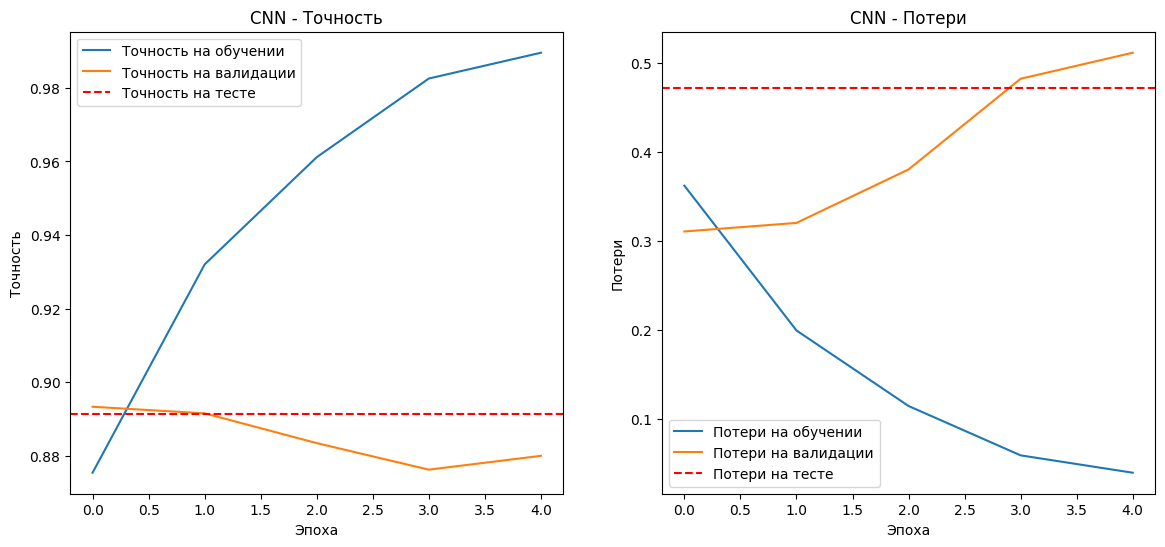

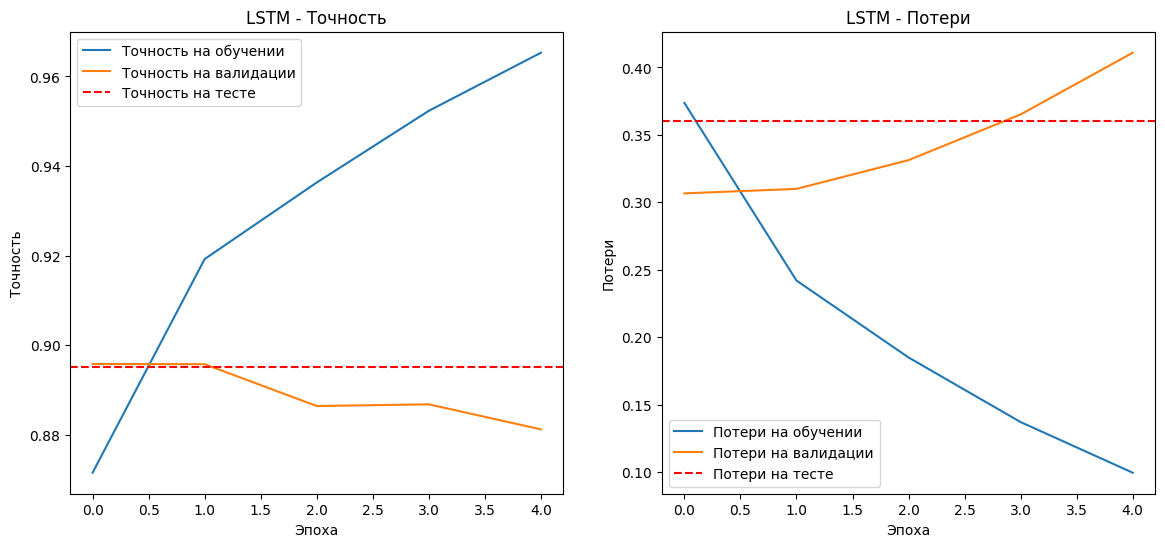

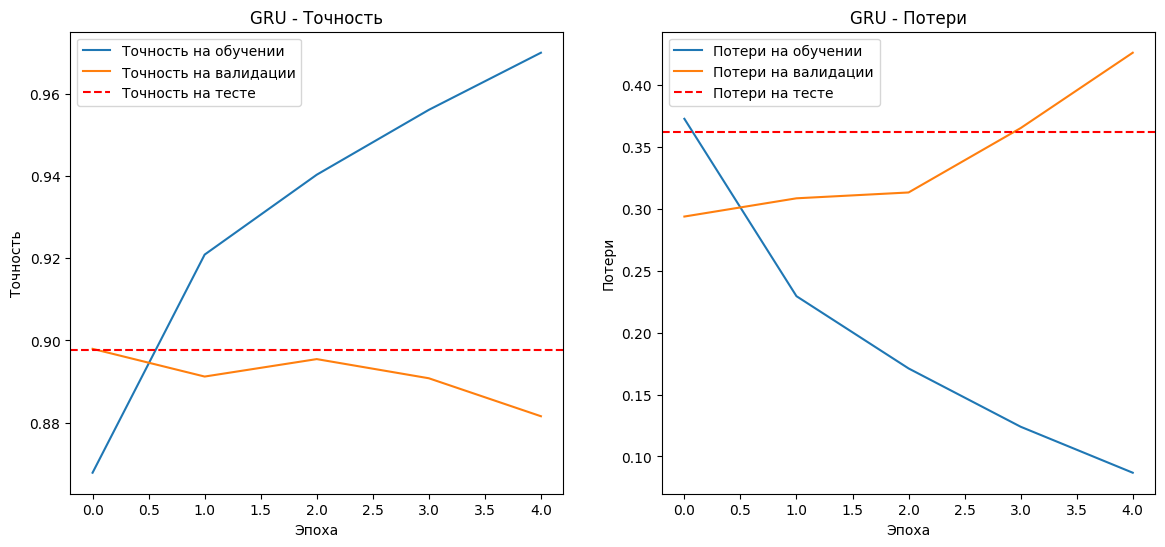

In [14]:
# Построение графиков обучения
def plot_full_training_history(history, model_name, test_acc, test_loss):
    plt.figure(figsize=(14, 6))

    # График точности
    plt.subplot(1, 2, 1)  # Создание подграфика (1 из 2) для точности
    plt.plot(history.history['accuracy'], label='Точность на обучении')  # Построение графика точности на обучении
    plt.plot(history.history['val_accuracy'], label='Точность на валидации')  # Построение графика точности на валидации
    plt.axhline(y=test_acc, color='r', linestyle='--', label='Точность на тесте')  # Добавление точности на тесте как горизонтальной линии
    plt.title(f'{model_name} - Точность')  # Установка заголовка графика
    plt.xlabel('Эпоха')  # Установка метки оси X
    plt.ylabel('Точность')  # Установка метки оси Y
    plt.legend()  # Добавление легенды к графику

    # График потерь
    plt.subplot(1, 2, 2)  # Создание подграфика (2 из 2) для потерь
    plt.plot(history.history['loss'], label='Потери на обучении')  # Построение графика потерь на обучении
    plt.plot(history.history['val_loss'], label='Потери на валидации')  # Построение графика потерь на валидации
    plt.axhline(y=test_loss, color='r', linestyle='--', label='Потери на тесте')  # Добавление потерь на тесте как горизонтальной линии
    plt.title(f'{model_name} - Потери')  # Установка заголовка графика
    plt.xlabel('Эпоха')  # Установка метки оси X
    plt.ylabel('Потери')  # Установка метки оси Y
    plt.legend()  # Добавление легенды к графику

    # Отображение графиков
    plt.show()

# Построение графиков для каждой модели
plot_full_training_history(history_cnn, 'CNN', cnn_acc, cnn_loss)
plot_full_training_history(history_lstm, 'LSTM', lstm_acc, lstm_loss)
plot_full_training_history(history_gru, 'GRU', gru_acc, gru_loss)


Время обучения

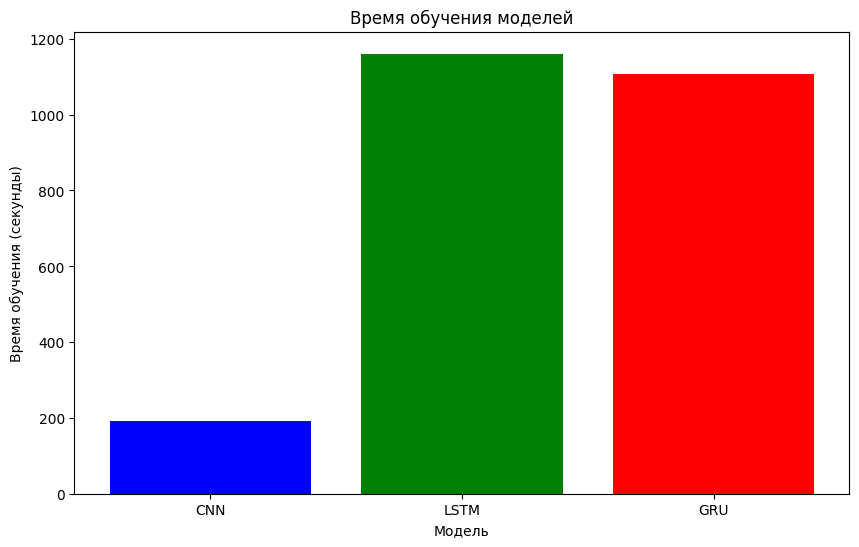

In [15]:
# Построение графика времени обучения
models = ['CNN', 'LSTM', 'GRU']  # Названия моделей
training_times = [cnn_time, lstm_time, gru_time]  # Времена обучения каждой модели

plt.figure(figsize=(10, 6))  # Создание фигуры для графика размером 10x6 дюймов
plt.bar(models, training_times, color=['blue', 'green', 'red'])  # Построение столбчатого графика
plt.xlabel('Модель')  # Установка метки оси X
plt.ylabel('Время обучения (секунды)')  # Установка метки оси Y
plt.title('Время обучения моделей')  # Установка заголовка графика
plt.show()  # Отображение графика


# Выводы:

Все модели переобучились, возможно необходимо изменить гиперпараметры для улучшения.